# Track TSMC with random forest

### Libraries

In [158]:
# Import Libraries
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression  # or RandomForestRegressor etc.
from sklearn.metrics import accuracy_score  # or mean_squared_error for regression
from datetime import time
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC  # SVM Classifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as pl

## Functions

In [161]:
def fetch_data(ticker, timespan = '10y'):
    data_temp = yf.download(ticker, period = timespan) #get data through API
    data_temp.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in data_temp.columns] #flatten the multi-index in column
    data_temp = data_temp.ffill() # remove rows with NaN
    return data_temp

In [163]:
def get_pct_diff_lastnight(data, open_ticker, close_ticker):
    df_temp = pd.DataFrame()
    df_temp['Prev_Close'] = data[close_ticker].shift(1)  # yesterday's close
    return (data[open_ticker] - df_temp['Prev_Close']) / df_temp['Prev_Close'] * 100  # today's open minus yesterday's close

In [165]:
def get_pct_change_lastday(data, ticker):
    df_temp = pd.DataFrame()
    df_temp['pct_change'] = data[ticker].pct_change() * 100
    return df_temp['pct_change'].shift(1)

In [167]:
def get_data_lastday(data, ticker):
    return data[ticker].shift(1)

In [169]:
def get_volume_lastday(data, ticker):
    df_temp = pd.DataFrame()
    df_temp['vol_lastday'] = data[ticker].shift(1)
    scaler = StandardScaler()
    return scaler.fit_transform(df_temp[['vol_lastday']]) #scaled vol

In [171]:
def get_diff_to_5d_avg_lastday(data, ticker):
    df_temp = pd.DataFrame()
    df_temp['five_day_avg'] = data[ticker].rolling(5).mean()
    df_temp['diff_to_5d_avg'] = data[ticker] - df_temp['five_day_avg']
    return df_temp['diff_to_5d_avg'].shift(1)

In [243]:
def get_diff_label(data, openticker, closeticker, threshold = 0.4):
    df_temp = pd.DataFrame()
    df_temp['diff'] = data[closeticker] - data[openticker]
    conditions = [
    df_temp['diff'] > threshold,
    df_temp['diff'].between(- threshold, threshold),
    df_temp['diff'] < - threshold
    ]
    choices = [1, np.nan, 0]
    return np.select(conditions, choices)


## Introduce Data from: 2330, S&P500, VIX, SOX, TSM

In [245]:
# fetch data
data = pd.DataFrame()
data = fetch_data(ticker = ['^GSPC', '2330.TW', 'TSM', '^VIX', '^SOX'])
# print(data.head(), '\n\n============================')

# data manipulation to get features
df = pd.DataFrame()
df['2330_diff_lastnight'] = get_pct_diff_lastnight(data, 'Open_2330.TW', 'Close_2330.TW')
df['2330_diff_to_5d_avg_lastday'] = get_diff_to_5d_avg_lastday(data, 'Close_2330.TW')

df['SP500_change_lastday'] = get_pct_change_lastday(data, 'Close_^GSPC')
df['SP500_vol_lastday'] = get_volume_lastday(data, 'Volume_^GSPC')
df['SP500_diff_to_5d_avg_lastday'] = get_diff_to_5d_avg_lastday(data, 'Close_^GSPC')

df['TSM_change_lastday'] = get_pct_change_lastday(data, 'Close_TSM')
df['TSM_vol_lastday'] = get_volume_lastday(data, 'Volume_TSM')
df['TSM_diff_to_5d_avg_lastday'] = get_diff_to_5d_avg_lastday(data, 'Close_TSM')

df['VIX_change_lastday'] = get_pct_change_lastday(data, 'Close_^VIX')
df['VIX_lastday'] = get_data_lastday(data, 'Close_^VIX')

df['SOX_change_lastday'] = get_pct_change_lastday(data, 'Close_^SOX')
df['SOX_lastday'] = get_data_lastday(data, 'Close_^SOX')


# print(df.head(10))


[*********************100%***********************]  5 of 5 completed


In [247]:
#get label
df['label'] = get_diff_label(data, openticker = 'Open_2330.TW', closeticker = 'Close_2330.TW', threshold = 0.5)
print(df.head())

            2330_diff_lastnight  2330_diff_to_5d_avg_lastday  \
Date                                                           
2015-05-29                  NaN                          NaN   
2015-06-01            -0.342442                          NaN   
2015-06-02            -0.344825                          NaN   
2015-06-03            -0.347227                          NaN   
2015-06-04            -0.699324                          NaN   

            SP500_change_lastday  SP500_vol_lastday  \
Date                                                  
2015-05-29                   NaN                NaN   
2015-06-01                   NaN          -0.123644   
2015-06-02              0.205946          -1.037297   
2015-06-03             -0.100860          -0.999740   
2015-06-04              0.211887          -0.949222   

            SP500_diff_to_5d_avg_lastday  TSM_change_lastday  TSM_vol_lastday  \
Date                                                                            
201

## Assign Labels Features
### (S&P lastnight, vol; 2330 diff overnight; VIX lastnight; TSM lasnight changes, vol; SOX lastnight changes

In [249]:
# Clean the df
df_clean = df.dropna()
print(df_clean.head(30))

# Split your dataset first
X = df_clean.drop(columns = ['label'], axis=1)  # features
y = df_clean['label']  # target
# print(X.head())
# print(y.head(30))
# print(df_clean(head(30))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scale features (recommended for SVM and others)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

            2330_diff_lastnight  2330_diff_to_5d_avg_lastday  \
Date                                                           
2015-06-08            -0.357135                    -1.951537   
2015-06-10             1.438851                    -0.975764   
2015-06-11             1.075258                    -0.075053   
2015-06-15             0.000008                     2.627063   
2015-06-16            -0.000019                     0.825655   
2015-06-23             0.704237                    -0.075063   
2015-06-25            -0.000014                     1.426137   
2015-06-26             0.341288                     1.876474   
2015-06-29            -0.706768                     0.900697   
2015-06-30             0.361003                    -1.558527   
2015-07-01            -0.355900                    -0.079883   
2015-07-02            -0.354582                     0.234669   
2015-07-03            -0.000007                     0.697005   
2015-07-08            -0.000021         

## Check correlation between features

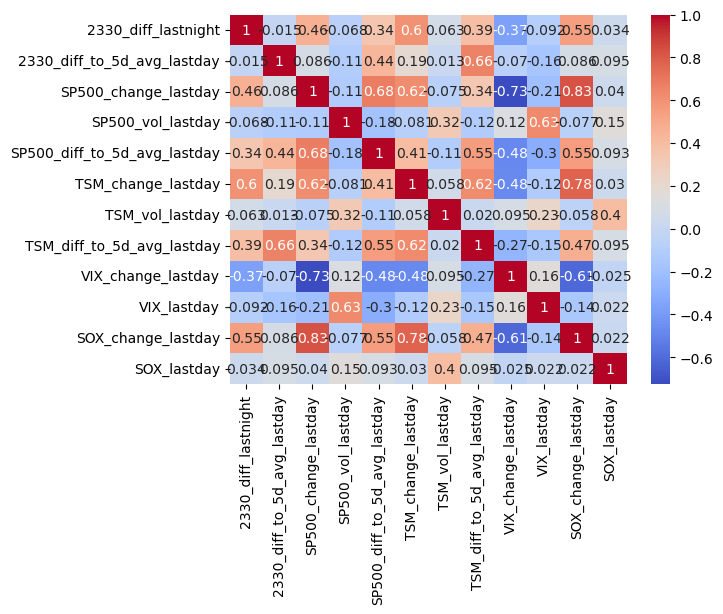

In [238]:
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

## Train the Model with SVM/Random Forest

In [270]:
model = SVC(kernel='rbf', C=10, gamma='auto')  # Common setup
model.fit(X_train, y_train)

SVC(C=10, gamma='auto')

In [278]:
# Using Random Forest
model = RandomForestClassifier(
    n_estimators=1000,  # number of trees
    max_depth=None,    # grow trees until all leaves are pure
    random_state=42
)

model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=42)

## Evaluate the Result

In [281]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.54


In [283]:
print(y_train.value_counts(normalize=True))

label
0.0    0.513038
1.0    0.486962
Name: proportion, dtype: float64


In [285]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.55      0.58      0.56       212
         1.0       0.53      0.51      0.52       201

    accuracy                           0.54       413
   macro avg       0.54      0.54      0.54       413
weighted avg       0.54      0.54      0.54       413



## Feature Importance

In [126]:
importances = model.feature_importances_
print(type(importances))
print(importances)

<class 'numpy.ndarray'>
[0.09327207 0.08248806 0.07753559 0.08065959 0.07987717 0.07787806
 0.08260529 0.08019532 0.07924994 0.08734192 0.07816981 0.10072718]


## Try finding Best-performing Hyper-perimeter

In [ ]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'poly', 'linear'],
    'gamma': ['scale', 'auto', 0.01, 0.001]
}

grid = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best score:", grid.best_score_)

## Potential Idea for features

In [ ]:
# ideas: volumn change(1d - 5d.avg), 